# Load Diffusion Model

In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras
import tensorflow as tf
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
"""Generate 10K DDPM Samples for FID and IS Computation"""
# Download model from Google Drive
print("Downloading model from Google Drive...")
gdrive_url = "https://drive.google.com/file/d/1oy-XeKTCkrjQ_SLRC8MmVV4VsaeXEwIq/view?usp=sharing"
file_id = "1oy-XeKTCkrjQ_SLRC8MmVV4VsaeXEwIq"
output_path = "diffusion_1000.keras"

# Download the file
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)
print(f"Model downloaded to: {output_path}")


Downloading...
From: https://drive.google.com/uc?id=1oy-XeKTCkrjQ_SLRC8MmVV4VsaeXEwIq
To: /content/diffusion_1000.keras
100%|██████████| 3.69M/3.69M [00:00<00:00, 13.8MB/s]

Model downloaded to: diffusion_1000.keras


# Define custom layers when loading the model

In [2]:

# Define TimeEncoding layer (needed for loading the model)
class TimeEncoding(tf_keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

# Load the trained model
print("\nLoading trained model...")
model = tf_keras.models.load_model(output_path,
                                     custom_objects={'TimeEncoding': TimeEncoding},
                                     compile=False)
print("Model loaded successfully!")



Loading trained model...
Model loaded successfully!


# Variance Scheduler

In [4]:
# Define variance schedule (same as training)
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta

T = 1000
alpha, alpha_cumprod, beta = variance_schedule(T)

# Helper Function

In [7]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


# Image Generation Phase

In [5]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
X_gen = generate(model)  # generated images


t = 1 

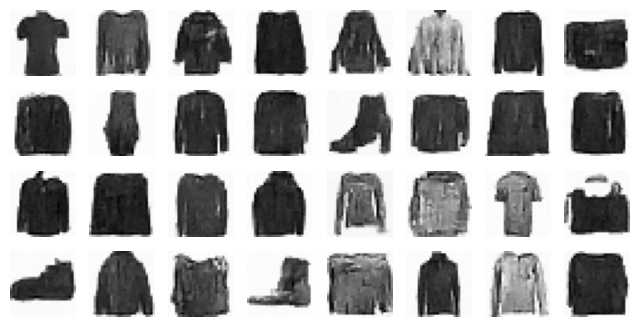

In [11]:

plot_multiple_images(X_gen.numpy(), 8)
plt.show()
